# Create plotting shapes
To make things a little easier, we'll add two simple shapes that contain the station locations as well as the lumped basin outlines in one file each. This way it'll be a little easier to plot things quickly.

In [1]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
from shapely.geometry import Point

In [2]:
# Data location
cs_main_folder = Path("/scratch/gwf/gwf_cmt/wknoben/camels-spat-upload")

In [3]:
# Destination location
cs_update_folder = Path("/scratch/gwf/gwf_cmt/wknoben/camels-spat-upload-updates")
cs_plot_folder = cs_update_folder / 'plotting'
cs_plot_folder.mkdir(exist_ok=True)

In [4]:
# Specify the folder structure
shape_path_part1 = "shapefiles"
shape_path_parts2 = ["headwater", "macro-scale", "meso-scale"]
shape_path_part3 = "shapes-lumped"

In [5]:
# Load the meta-data, so we known which basins we have
cs_meta = pd.read_csv(cs_main_folder / "camels-spat-metadata.csv")

## Create the merged shapes

#### Basins

In [6]:
all_basin_shps = []
all_basin_ids = []
for shape_path_part2 in shape_path_parts2:

    # 1. Find the basin folders - note we get these from update folder to get unitarea as well
    shape_middle = f"{shape_path_part1}/{shape_path_part2}/{shape_path_part3}"
    basin_paths = [f for f in (cs_update_folder / shape_middle).iterdir() if f.is_dir()]

    # 2. Loop over the identified folders
    for basin_path in basin_paths:

        # 2.1. Extract the basin ID
        basin_id = basin_path.name
        all_basin_ids.append(basin_id) # just the final part, e.g. USA_08164300
        
        # 2.2. Load the lumped basin shapefile
        all_basin_shps.append(gpd.read_file(basin_path / f"{basin_id}_lumped.shp"))

In [7]:
# merge
basin_gdf = gpd.GeoDataFrame(pd.concat(all_basin_shps, ignore_index=True))

In [8]:
# add metadata
basin_gdf['tmp'] = all_basin_ids
basin_gdf[['Country','Station_id']] = basin_gdf['tmp'].str.split("_", expand=True)

In [9]:
# order to match cs_meta
basin_gdf = basin_gdf.set_index('Station_id').loc[cs_meta['Station_id']].reset_index()

In [10]:
# add names (might as well do it on ID even though order should be same now)
basin_gdf = basin_gdf.merge(cs_meta[['Station_id','Station_name','Delineation_confidence']],
                            on='Station_id', how='left')

In [11]:
# reshuffle columns and drop tmp
basin_gdf = basin_gdf[['Country', 'Station_id', 'Station_name', 'unitarea', 
                       'Delineation_confidence','geometry']]

In [12]:
# rename
basin_gdf = basin_gdf.rename(columns={'Station_name': 'Statn_name',
                                      'unitarea' : 'Area_km2',
                                      'Delineation_confidence': 'Delin_conf'})

In [13]:
# set crs
basin_gdf = basin_gdf.set_crs(epsg=4326);

In [14]:
# to file
basin_gdf.to_file(cs_plot_folder / 'camels_spat_all_basin_outlines.shp', index=False)

In [15]:
test_basins = gpd.read_file(cs_plot_folder / 'camels_spat_all_basin_outlines.shp')
test_basins.head(2)

,Country,Station_id,Statn_name,Area_km2,Delin_conf,geometry
0,CAN,01AD003,ST. FRANCIS RIVER AT OUTLET OF GLASIER LAKE,1343.736232,high,"MULTIPOLYGON (((-69.04125 47.21125, -69.04208 ..."
1,CAN,01AF007,GRANDE RIVIERE AT VIOLETTE BRIDGE,323.834471,high,"POLYGON ((-67.67625 47.45375, -67.67542 47.453..."


/opt/software/custom/software/2020/avx2/MPI/gcc9/openmpi4/geo-stack/2022a/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


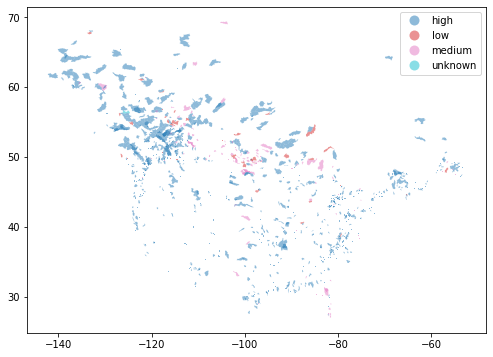

In [16]:
test_basins.plot(column='Delin_conf', alpha=0.5, legend=True, figsize=(10,6));

#### Stations

In [17]:
# initial gdf from cs_meta: use reported station locations, not our delineation locations
geometries = [Point(xy) for xy in zip(cs_meta['Station_lon'], cs_meta['Station_lat'])]
station_gdf = gpd.GeoDataFrame(cs_meta[['Country', 
                                'Station_id', 
                                'Station_name',
                                'Delineation_confidence']],
                       geometry=geometries)

In [19]:
# Add unit area by matching with basins_gdf
station_gdf = station_gdf.merge(basin_gdf[['Station_id','Area_km2']],
                            on='Station_id', how='left')

In [20]:
# rename
station_gdf = station_gdf.rename(columns={'Station_name': 'Statn_name',
                          'Delineation_confidence': 'Delin_conf'})

In [21]:
# re-order
station_gdf = station_gdf[['Country', 'Station_id', 'Statn_name', 'Area_km2', 
                           'Delin_conf','geometry']]

In [22]:
# set crs
station_gdf = station_gdf.set_crs(epsg=4326)

In [23]:
# to file
station_gdf.to_file(cs_plot_folder / 'camels_spat_all_station_locations.shp', index=False)

In [24]:
test_stations = gpd.read_file(cs_plot_folder / 'camels_spat_all_station_locations.shp')
test_stations.head(2)

,Country,Station_id,Statn_name,Area_km2,Delin_conf,geometry
0,CAN,01AD003,ST. FRANCIS RIVER AT OUTLET OF GLASIER LAKE,1343.736232,high,POINT (-68.95694 47.20661)
1,CAN,01AF007,GRANDE RIVIERE AT VIOLETTE BRIDGE,323.834471,high,POINT (-67.92128 47.24697)


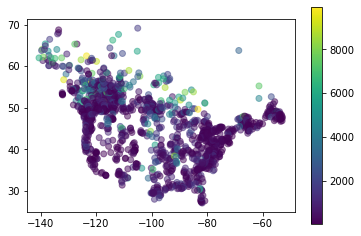

In [26]:
test_stations.plot(column='Area_km2', alpha=0.5, legend=True);